In [0]:
!sudo add-apt-repository ppa:alessandro-strada/google-drive-ocamlfuse-beta
!sudo apt-get update
!sudo apt-get install google-drive-ocamlfuse

In [0]:
from oauth2client.client import GoogleCredentials
from google.colab import auth, files
import getpass
auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {getpass.getpass()} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive && google-drive-ocamlfuse drive

In [0]:
import sys
sys.path.insert(0, 'drive/ColabNotebooks')

In [0]:
import os
import cv2
import sys
import shutil
import numpy as np

myPath = "drive/ColabNotebooks/images/"

fileNames = [f for f in os.listdir(myPath) if os.path.isfile(os.path.join(myPath, f))]

print(str(len(fileNames)) + ' images loaded...')

dogCount = 0
catCount = 0
trainingSize = 1000
testSize = 500
trainingImgs = []
trainingLabels = []
testImgs = []
testLabels = []
size = 150
dogTrainDir = "drive/ColabNotebooks/datasets3/catvsdog/train/dogs/"
catTrainDir = "drive/ColabNotebooks/datasets3/catvsdog/train/cats/"
dogTestDir = "drive/ColabNotebooks/datasets3/catvsdog/test/dogs/"
catTestDir = "drive/ColabNotebooks/datasets3/catvsdog/test/cats/"

def make_dir(dir):
  if os.path.exists(dir):
    shutil.rmtree(dir)
  os.makedirs(dir)
  
make_dir(dogTrainDir)
make_dir(catTrainDir)
make_dir(dogTestDir)
make_dir(catTestDir)

def get_zeros(number):
  if(number > 10 and number < 100):
    return "0"
  if(number < 10):
    return "00"
  else:
    return ""
  
for i, file in enumerate(fileNames):
  
  if(fileNames[i][0] == "d"):
    dogCount += 1
    img = cv2.imread(myPath+file)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    
    if(dogCount <= trainingSize):
        trainingImgs.append(img)
        trainingLabels.append(1)
        zeros = get_zeros(dogCount)
        cv2.imwrite(dogTrainDir + "dog" + str(zeros) + str(dogCount) + ".jpg", img)
        
    if(dogCount > trainingSize and dogCount <= trainingSize + testSize):
        testImgs.append(img)
        testLabels.append(1)
        zeros = get_zeros(dogCount - 1000)
        cv2.imwrite(dogTestDir + "dog" + str(zeros) + str(dogCount - 1000) + ".jpg", img)
        
  if(fileNames[i][0] == "c"):
    catCount += 1
    img = cv2.imread(myPath+file)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    
    if(catCount <= trainingSize):
        trainingImgs.append(img)
        trainingLabels.append(1)
        zeros = get_zeros(catCount)
        cv2.imwrite(catTrainDir + "cat" + str(zeros) + str(catCount) + ".jpg", img)
        
    if(catCount > trainingSize and catCount <= trainingSize + testSize):
        testImgs.append(img)
        testLabels.append(1)
        zeros = get_zeros(catCount - 1000)
        cv2.imwrite(catTestDir + "cat" + str(zeros) + str(catCount - 1000) + ".jpg", img)
        
  if(dogCount == trainingSize + testSize and catCount == trainingSize + testSize):
    break
        
print("Completed!")

In [0]:
np.savez("drive/training_data.npz", np.array(trainingImgs))
np.savez("drive/training_labels.npz", np.array(trainingLabels))
np.savez("drive/test_data.npz", np.array(testImgs))
np.savez("drive/test_labels.npz", np.array(testLabels))

In [0]:
import numpy as np

def load_catdog_dataset():
  
  npzFile = np.load("drive/train.npz")
  train = npzFile['arr_0']
  
  npzFile = np.load("drive/train_labels.npz")
  trainLabels = npzFile['arr_0']
  
  npzFile = np.load("drive/test.npz")
  test = npzFile['arr_0']
  
  npzFile = np.load("drive/test_labels.npz")
  testLabels = npzFile['arr_0']
  
  return train, trainLabels, test, testLabels


x_train, y_train, x_test, y_test = load_catdog_dataset()

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 150, 150, 3)
(1000, 150, 150, 3)
(2000, 1)
(1000, 1)


In [0]:
from google.colab.patches import cv2_imshow

for i in range(10):
  random = np.random.randint(0, len(x_test))
  img = x_test[random]
  print(y_test[random])
  cv2_imshow(img)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

epochs = 25
batchSize = 16
inputShape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print(model.summary())

history = model.fit(x_train, y_train, batch_size = batchSize, epochs = epochs, validation_data = (x_test, y_test), shuffle = True)
          
model.save("drive/ColabNotebooks/catsvsdogs.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)        18496     
__________

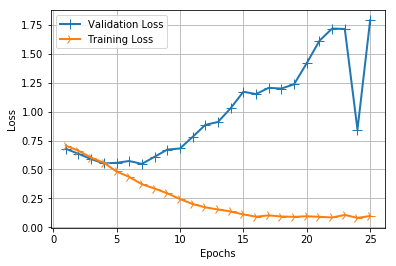

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label="Validation Loss")
line2 = plt.plot(epochs, loss_values, label="Training Loss")
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

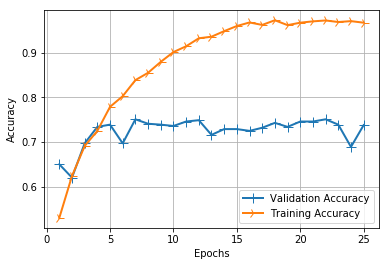

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label="Validation Accuracy")
line2 = plt.plot(epochs, acc_values, label="Training Accuracy")
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

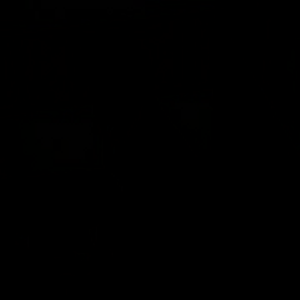

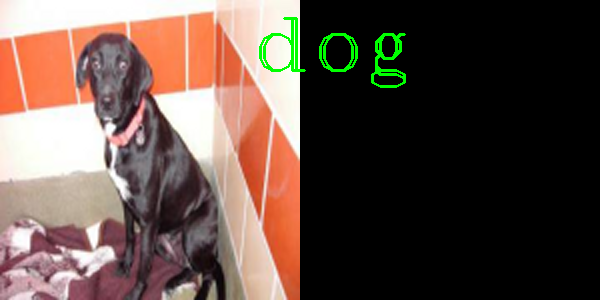

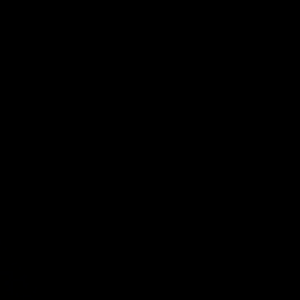

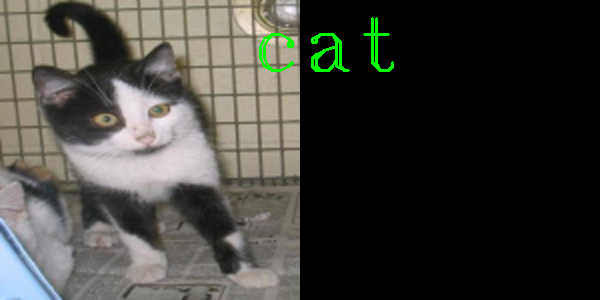

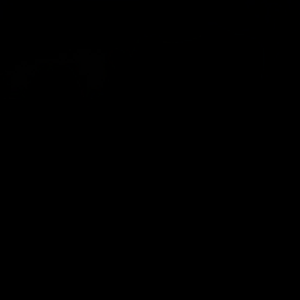

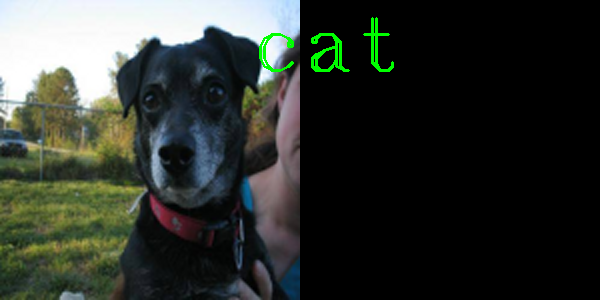

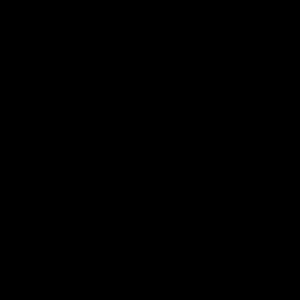

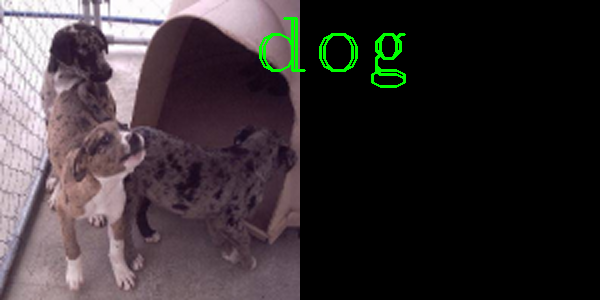

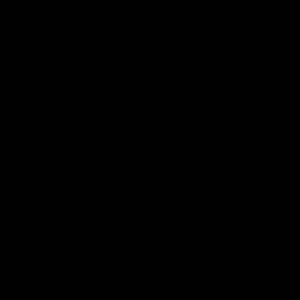

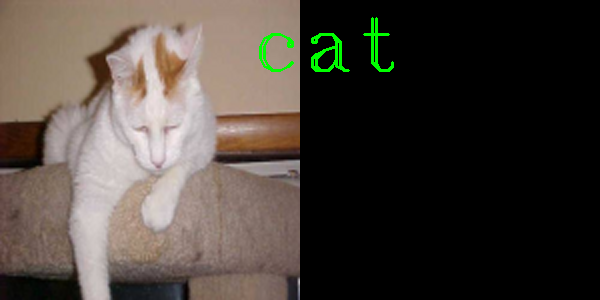

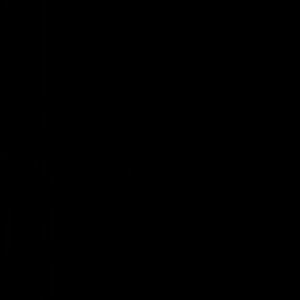

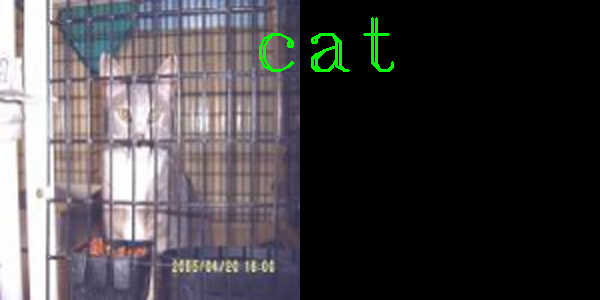

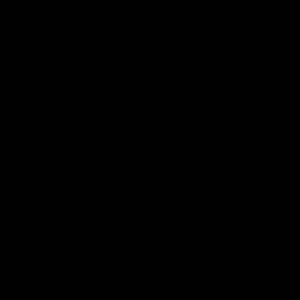

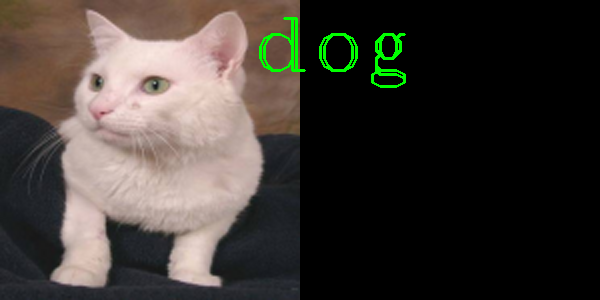

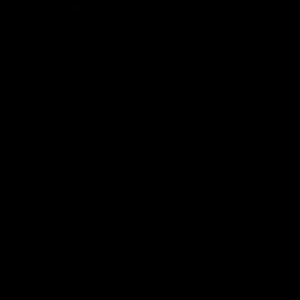

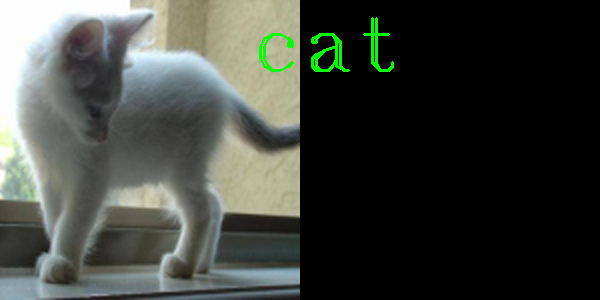

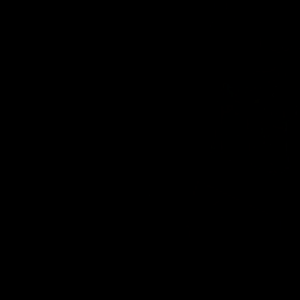

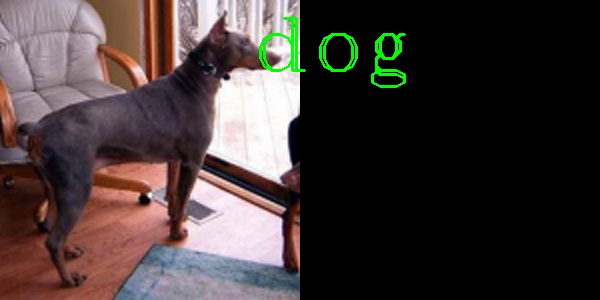

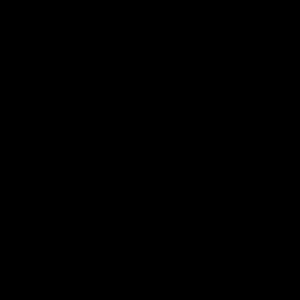

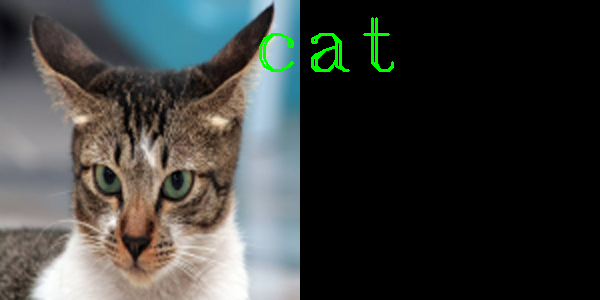

In [0]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

classifier = load_model('drive/ColabNotebooks/catsvsdogs.h5')

def draw_test(name, pred, inputImg):
  BLACK = [0, 0, 0]
  if pred == "[0]":
    pred = "cat"
  if pred == "[1]":
    pred = "dog"
  expandedImg = cv2.copyMakeBorder(inputImg, 0, 0, 0, imageL.shape[0], cv2.BORDER_CONSTANT, value=BLACK)
  cv2.putText(expandedImg, str(pred), (252, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 4, (0, 255, 0), 2)
  cv2_imshow(expandedImg * 255)
  
for i in range(10):
  rand = np.random.randint(0, len(x_test))
  inputImg = x_test[rand]
  
  imageL = cv2.resize(inputImg, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
  cv2_imshow(imageL)
  
  inputImg = inputImg.reshape(1, 150, 150, 3)
  
  res = str(classifier.predict_classes(inputImg, 1, verbose = 0)[0])
  
  draw_test("Prediction", res, imageL)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

inputShape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
          
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
          
print(model.summary())
          
history = model.fit_generator(ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, 
                                       horizontal_flip = True).flow(x_train, y_train, 16),
                                       steps_per_epoch=len(x_train) / 16, epochs=25, verbose=1, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_26 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)        18496     
__________

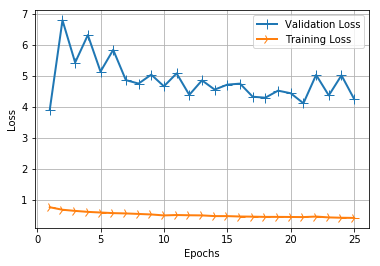

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label="Validation Loss")
line2 = plt.plot(epochs, loss_values, label="Training Loss")
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

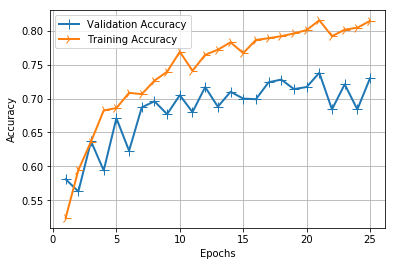

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label="Validation Accuracy")
line2 = plt.plot(epochs, acc_values, label="Training Accuracy")
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict_classes(x_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.47      1000
   macro avg       0.50      0.23      0.32      1000
weighted avg       1.00      0.47      0.64      1000

[[470 530]
 [  0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
